<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-final-project/blob/main/dtsa5511_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bank of Canada interest rate changes using deep learning
DTSA5511 final project

**Repo link:**

In [135]:
!pip install scikit-learn-intelex -q
!pip install scikeras -q
!pip install keras-tuner --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [138]:
# file handling & general
import itertools
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import random
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')
from functools import reduce

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# ml
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import ParameterGrid


import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LayerNormalization, GRU, LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt
from keras_tuner import RandomSearch


## 1 Introduction

In Canada, we have a highly centralized banking system, with the Bank of Canada at the top, 6 large commercial banks that operate at the national scale, and large number of small co-operatively owned credit unions and lending institutions serving their local communities. The Bank of Canada (herein referred to the BoC) exercises counter-inflationary monetary policy by increasing interest to slow inflation (the overall increase in prices of consumer goods and services over time), and decreasing interest to allow to avoid deflation or recession (1).

The BoC does this by adjusting the key interest rate at 8 pre-determined times per year (2). The key interest rate is what the BoC sets as the bench mark for interest rates charged to customers by commercial banks and other lending institutions in Canada. Changes in interest rates and its affects are important to society as a whole. Consider the case of a real estate developer - during periods of economic stagnation, the BoC will lower interest rates to stimulate the spending in the economy. A lower interest rate means that housing projects are now more affordable for the developer, construction on a large project begins, construction crews bring home a paycheque to support their families, and the money is further spent on goods and services within the economy.

Regardless of whether a person has a mortgage on a house or car loan payments, interest rates will always have some sort of affect on nearly every aspect of a Canadian's life. A retail grocery chain, for a simple example, often holds commercial loans for its buildings or to assist with inventory purchasing in advance of a busy season. A substantial rise in interest rates means higher loan payments for the store, which ultimately must be paid for by consumers in the form of higher grocery prices.

**The Problem:** Knowing in which way interest rates may change in advance of an annoucement from the BoC would be extremely helpful in any industry for short and long term project planning. The goal of this project is create a deep learning model to use several economic indicators to predict and classify whether the interest rate will decrease, hold steady, or increase in advance of an announcement. Economic data is a time series, so this project will require the use of a Recurrent Neural Network (RNN).


The use of deep learning is a fairly new tool for central banks in the last decade. Deep learning allows hundreds or even thousands of variables to be used in prediction models.

### 1.1 The data

The announcement dates for interest rate changes was found on the BoC website (3). Info from reports containing the 8 yearly announcement dates the years 2001 to 2025 was entered into a .csv and saved into the repository.

The majority of the economic indicators were mined from the Statistics Canada Website (4). Each series within a data table has a uniqu vector ID number which can be view when downloaded as a .csv using the 'for database loading' option.

**_The target feature (decrease, hold, or increase) will be derived from the interest rate series._**

As this project will not be graded on the economic reasoning, I will not go into WHY these 14 features were included:

* FEATURE, STATCAN TABLE ID, VECTOR ID
* interest rate - the target feature will be derived from this series
* wages -
* raw materials price index -
* consumer price index -
* housing starts, 34-10-0156, v52299896 **REMOVED** due to inconsistent availability
* building permits, 34-10-0292, v1675119645 **REMOVED** avail > 2018-01 only
* retail trade, 20-10-0067, v1446870183 **REMOVED** due to inconsistent availability
* unemployment rate, 14-10-0287, v2062815
* employment rate, 14-10-0287, v2062817
* labour force participation rate, 14-10-0287, v2062816
* GDP (all industries), 36-10-0434, v65201210
* manufacturing industrial production index, 18-10-0267, v1230996350
* manufacturing capacity utilization rate, 16-10-0015, v1707053279 **REMOVED** due to inconsistent availability
* top trading partner - US exchange rate, 33-10-0036, v111666248
* top trading partner - Chinese renminbi exchange rate, 33-10-0036, v111666226
* top trading partner - EU Euro, 33-10-0036, v111666227
* top trading partner - Japanese yen, 33-10-0036, v111666231
* S&P TSX composite close, 10-10-0125, v122620

Exchange rates before 2017 were not available from Statistics Canada and needed to be attained from the BoC website (5) and save to the repo data folder.

Values for the TSX close after 2023 were not available from Statistics Canada and needed to be attained from Yahoo! Finance (6) and saved to the repo data folder.

When all data has been concatenated, it will have 288 observations and 15 features in tabular format.

In [3]:
# boc rate announcement dates, incl 2025
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/rate-announcements.csv'

rate_announcements = pd.read_csv(url)

print(rate_announcements.info())

print('\n', rate_announcements.tail(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    201 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB
None

            date
193  2025-01-29
194  2025-03-12
195  2025-04-16
196  2025-06-04
197  2025-07-30
198  2025-09-17
199  2025-10-29
200  2025-12-10


### 1.2 Wrangling & cleaning

The data for the economic indicators will be in a monthly format using the first day of the month. The interest rate change days vary each announcement, so the dates needed to be adjusted.

In [4]:
# function to preprocess announcement feature
def preprocess_rate_announcements(rate_announcements):
    '''
    peprocesses rate announcement data by:
    - parsing dates
    - normalizing them to the first day of the month
    - creating a binary 'announcement' column
    - renaming 'date' to 'Date'

    Args:
        rate_announcements (pd.DataFrame): df containing 'date' column.

    Returns:
        pd.DataFrame: df with 'Date' column (monthly), and an 'announcement' column.
    '''

    # check if date exists
    if 'date' not in rate_announcements.columns:
        raise ValueError('input df must contain a "date" column')

    rate_announcements['date'] = pd.to_datetime(rate_announcements['date'])

    # normalize to first day of month
    rate_announcements['Date'] = (rate_announcements['date'].dt.to_period('M')
                                                            .dt.to_timestamp())

    # add binary flag for announcem ent
    rate_announcements['announcement'] = 1

    # drop duplicates
    rate_announcements = rate_announcements.drop_duplicates(subset = 'Date')

    # keep relevant columns
    return rate_announcements[['Date', 'announcement']]

In [5]:
rate_announcements = preprocess_rate_announcements(rate_announcements)
print(rate_announcements.info())
print(rate_announcements.head())

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 200
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          200 non-null    datetime64[ns]
 1   announcement  200 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.7 KB
None
        Date  announcement
0 2001-01-01             1
1 2001-03-01             1
2 2001-04-01             1
3 2001-05-01             1
4 2001-07-01             1


In [6]:
# base URL for statcan data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    'message': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    'common': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}

Some data series are reported daily, other series are reported monthly, quarterly or annually. To address the various reporting periods, I need a method to fill the NA values. I had a little outside help to get this to work properly (7).

In [7]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''Initialize with a dataframe of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''Extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''Transform the XML response into a structured DataFrame'''
        root = ET.fromstring(xml_content)
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # Convert date format
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''Convert quarterly date string (YYYY-Qx) to standard YYYY-MM format'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''Load df into global object with name `name` (e.g., wage, rmpi)'''
        globals()[name] = df
        self.data_objects[name] = df
        print(f'Data for {name} saved to object {name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')


In [8]:
# metadata - info to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi',
             'house_st', # removed building permits & retail
             'unemp', 'empl', 'lab_part',
             'gdp', 'mf_ipi', # removed mf_cap
             'us_fx', 'cn_fx', 'eu_fx',
             'jp_fx', 'tsx_cl', 'rate'],
    'tableid': [14100223, 18100268, 18100004,
                34100156,  # removed building permits & retail
                14100287, 14100287, 14100287,
                36100434, 18100267, # removed mf_cap
                33100036, 33100036, 33100036,
                33100036, 10100125, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seas adj, 2002 = 100',
                  'housing starts',
                  'unemployment rate',
                  'employment rate',
                  'labour force participation rate',
                  'gross domestic product',
                  'manufacturing indust prod idx',
                  'usd exchange rate',
                  'china renminbi exchange rate',
                  'euro exchange rate',
                  'japan yen exchange',
                  's&p tsx close',
                  'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973',
               'v52299896', # removed bldg & retail
               'v2062815', 'v2062817', 'v2062816',
               'v65201210', 'v1230996350', # removed mf_cap
               'v111666275', 'v111666253', 'v111666254',
               'v111666258', 'v122620', 'v39078'],
    'frequency': ['monthly', 'monthly', 'monthly',
                  'monthly', # removed bldg & retail
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', # removed mf_cap
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', 'daily'],
    'start': ['2001-01', '2001-01', '2001-01',
              '2001-01', # removed bldg & retail
              '2001-01','2001-01', '2001-01',
              '2001-01','2001-01', # removed mf_cap
              '2017-01-01', '2017-01-01', '2017-01-01',
              '2017-01-01', '2001-01-01', '2001-01-01'], # nts: if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12',
            '2024-12', # removed bldg & retail
            '2024-12', '2024-12', '2024-12',
            '2024-12', '2024-12', # removed mf_cap
            '2024-12-31', '2024-12-31', '2024-12-31',
            '2024-12-31', '2024-12', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [9]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage
Processing rmpi...
Data for rmpi saved to object rmpi
Processing cpi...
Data for cpi saved to object cpi
Processing house_st...
Data for house_st saved to object house_st
Processing unemp...
Data for unemp saved to object unemp
Processing empl...
Data for empl saved to object empl
Processing lab_part...
Data for lab_part saved to object lab_part
Processing gdp...
Data for gdp saved to object gdp
Processing mf_ipi...
Data for mf_ipi saved to object mf_ipi
Processing us_fx...
Data for us_fx saved to object us_fx
Processing cn_fx...
Data for cn_fx saved to object cn_fx
Processing eu_fx...
Data for eu_fx saved to object eu_fx
Processing jp_fx...
Data for jp_fx saved to object jp_fx
Processing tsx_cl...
Data for tsx_cl saved to object tsx_cl
Processing rate...
Data for rate saved to object rate


In [ ]:
# check if data loaded correctly. Hashed out to save space.

#for key, value in pipeline.data_objects.items():
#    print(key)
#    print(value.head(2), '\n')

In [10]:
# variable list
variables = ['wage', 'rmpi', 'cpi', 'house_st', # removed bldg & retail
             'unemp', 'empl', 'lab_part', 'gdp', 'mf_ipi', # removed mf_cap
             'us_fx', 'cn_fx', 'eu_fx', 'jp_fx', 'tsx_cl', 'rate']

daily = ['tsx_cl']

# cleaning functions
def rename_value_column(vars_list):
    ''' rename "Value" column to variable name'''
    for var in vars_list:
        df = globals()[var]
        df.rename(columns={'Value': var},
                  inplace = True)

def convert_daily_to_monthly(daily_vars):
    ''' convert daily dataframes to monthly avgs '''
    for var in daily_vars:
        df = globals()[var].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = (df['Date'].dt.to_period('M')
                                 .dt.to_timestamp())
        df_monthly = (df.groupby('Month', as_index = False)[var]
                        .mean())
        df_monthly.rename(columns = {'Month': 'Date'},
                          inplace=True)
        globals()[var] = df_monthly

def preprocess_rate(rate_df):
    ''' cleans and transforms daily interest rate DataFrame to monthly,
    applying the new rate to the first day of the month of change
    '''
    rate_df['Date'] = pd.to_datetime(rate_df['Date'])
    rate_df['rate'] = pd.to_numeric(rate_df['rate'],
                                    errors = 'coerce')

    rate_df = rate_df.sort_values('Date')
    rate_df['prev_rate'] = rate_df['rate'].shift(1)
    rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']

    rate_changes = rate_df[rate_df['rate_changed']].copy()
    rate_changes['Date'] = (rate_changes['Date'].dt.to_period('M')
                                                .dt.to_timestamp())
    rate_changes = (rate_changes.groupby('Date')['rate']
                                .last()
                                .reset_index())
    monthly_rate_df = (rate_changes.set_index('Date')
                                   .resample('MS')
                                   .ffill()
                                   .reset_index())
    return monthly_rate_df

def ensure_date_datetime(vars_list):
    ''' ensure all 'Date' columns are datetime dtype '''
    for var in vars_list:
        df = globals()[var]
        df['Date'] = pd.to_datetime(df['Date'])

def merge_on_date(vars_list):
    ''' mrge all dataframes on 'Date' column using outer join '''
    dfs = [globals()[var] for var in vars_list]
    merged = reduce(lambda left,
                    right: pd.merge(left,
                                    right,
                                    on = 'Date',
                                    how = 'outer'), dfs)
    return merged

In [11]:
# run cleaning functions
rename_value_column(variables)

convert_daily_to_monthly(daily)

rate = preprocess_rate(rate)

ensure_date_datetime(variables)

# merge
data = merge_on_date(variables)

In [12]:
# date should be datetime
data['Date'] = pd.to_datetime(data['Date'])
rate_announcements['Date'] = pd.to_datetime(rate_announcements['Date'])

# merge
merged_data = pd.merge(data,
                       rate_announcements,
                       on = 'Date',
                       how = 'left')

# fill na announcements
merged_data['announcement'] = merged_data['announcement'].fillna(0).astype(int)

In [13]:
print(data.head(2))

        Date    wage  rmpi   cpi  house_st  unemp  empl  lab_part        gdp  \
0 2001-01-01  657.14  65.2  96.3   141.470    6.9  61.4      65.9  1434295.0   
1 2001-02-01  653.59  65.8  96.8   126.744    7.0  61.3      65.9  1433843.0   

   mf_ipi  us_fx  cn_fx  eu_fx  jp_fx   tsx_cl  rate  
0    77.1    NaN    NaN    NaN    NaN  9321.87  5.75  
1    77.5    NaN    NaN    NaN    NaN  8078.72  5.75  


In [14]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      288 non-null    datetime64[ns]
 1   wage      288 non-null    float64       
 2   rmpi      288 non-null    float64       
 3   cpi       288 non-null    float64       
 4   house_st  288 non-null    float64       
 5   unemp     288 non-null    float64       
 6   empl      288 non-null    float64       
 7   lab_part  288 non-null    float64       
 8   gdp       288 non-null    float64       
 9   mf_ipi    288 non-null    float64       
 10  us_fx     96 non-null     float64       
 11  cn_fx     96 non-null     float64       
 12  eu_fx     96 non-null     float64       
 13  jp_fx     96 non-null     float64       
 14  tsx_cl    273 non-null    float64       
 15  rate      288 non-null    float64       
dtypes: datetime64[ns](1), float64(15)
memory usage: 36.1 KB
None


In [15]:
# load historical foreign exchange (fx) rates
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/fx-2001-2016%20-%20fx-2001-2017.csv'
hist_fx = pd.read_csv(url)
hist_fx['Date'] = pd.to_datetime(hist_fx['date'])
hist_fx = hist_fx.drop(columns=['date'])
hist_fx.tail()

,cn_fx,eu_fx,jp_fx,us_fx,Date
187,0.1954,1.4563,0.01284,1.299323,2016-08-01
188,0.1965,1.4704,0.01288,1.310233,2016-09-01
189,0.1968,1.4594,0.01275,1.325305,2016-10-01
190,0.1963,1.4486,0.01238,1.343990,2016-11-01
191,0.1926,1.4060,0.01150,1.333565,2016-12-01


In [16]:
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/tsx_cl-2023-2024.csv'

hist_tsx = pd.read_csv(url)
hist_tsx['tsx_cl'] = hist_tsx['tsx_cl'].str.replace(',', '').astype(float)
hist_tsx['Date'] = pd.to_datetime(hist_tsx['Date'])
hist_tsx['Month'] = hist_tsx['Date'].dt.to_period('M').dt.to_timestamp()

# daily to monthly avgs. should have gotten monthly data to begin with!
tsx_monthly = hist_tsx.groupby('Month', as_index = False)['tsx_cl'].mean()

tsx_monthly.rename(columns = {'Month': 'Date'}, inplace = True)


print(tsx_monthly.head())
tsx_monthly.head()

        Date        tsx_cl
0 2023-10-01  19204.652381
1 2023-11-01  19897.900000
2 2023-12-01  20590.873684
3 2024-01-01  20976.054545
4 2024-02-01  21116.205000


,Date,tsx_cl
0,2023-10-01,19204.652381
1,2023-11-01,19897.900000
2,2023-12-01,20590.873684
3,2024-01-01,20976.054545
4,2024-02-01,21116.205000


In [17]:
# merge hist_fx into data
data = pd.merge(merged_data,
                hist_fx,
                on = 'Date',
                how = 'outer',
                suffixes = ('', '_hist'))

# fill missing fx rates from historical
fx_vars = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']

for var in fx_vars:
    hist_col = f'{var}_hist'
    if hist_col in data.columns:
        data[var] = data[var].fillna(data[hist_col])
        data.drop(columns = hist_col,
                  inplace = True)

print(data.head())

        Date    wage  rmpi   cpi  house_st  unemp  empl  lab_part        gdp  \
0 2001-01-01  657.14  65.2  96.3   141.470    6.9  61.4      65.9  1434295.0   
1 2001-02-01  653.59  65.8  96.8   126.744    7.0  61.3      65.9  1433843.0   
2 2001-03-01  655.14  65.5  97.1   131.271    7.1  61.2      66.0  1434685.0   
3 2001-04-01  652.44  65.2  97.8   144.474    7.1  61.3      66.0  1433399.0   
4 2001-05-01  652.28  65.3  98.6   139.901    7.0  61.3      66.0  1439506.0   

   mf_ipi     us_fx   cn_fx   eu_fx     jp_fx   tsx_cl  rate  announcement  
0    77.1  1.502864  0.1816  1.4099  0.012875  9321.87  5.75             1  
1    77.5  1.523125  0.1839  1.4008  0.013096  8078.72  5.75             0  
2    77.8  1.558441  0.1883  1.4154  0.012829  7608.00  5.25             1  
3    78.2  1.558495  0.1882  1.3906  0.012588  7946.63  5.00             1  
4    78.5  1.541123  0.1862  1.3482  0.012670  8161.87  4.75             1  


In [18]:
# add tsx data

data = data.reset_index()

# date columns format
data['Date'] = (pd.to_datetime(data['Date']).dt.to_period('M').dt.to_timestamp())
tsx_monthly['Date'] = (pd.to_datetime(tsx_monthly['Date']).dt.to_period('M').dt.to_timestamp())

# merge tsx vals
data = pd.merge(data, tsx_monthly,
                on = 'Date',
                how = 'left',
                suffixes = ('', '_new'))

# use new tsx_cl vals
data['tsx_cl'] = data['tsx_cl_new'].combine_first(data['tsx_cl'])


data.drop(columns = ['tsx_cl_new'], inplace=True)
data = data.set_index('Date')

print(data.loc['2023-09-01':'2024-02-01', ['tsx_cl']])

                  tsx_cl
Date                    
2023-09-01  19541.270000
2023-10-01  19204.652381
2023-11-01  19897.900000
2023-12-01  20590.873684
2024-01-01  20976.054545
2024-02-01  21116.205000


In [19]:
data.reset_index(inplace = True)


In [20]:
data.drop(columns = 'index',
          inplace  = True)
data.head(2)

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,77.1,1.502864,0.1816,1.4099,0.012875,9321.87,5.75,1
1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,77.5,1.523125,0.1839,1.4008,0.013096,8078.72,5.75,0


In [21]:
# descriptive stats
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          288 non-null    datetime64[ns]
 1   wage          288 non-null    float64       
 2   rmpi          288 non-null    float64       
 3   cpi           288 non-null    float64       
 4   house_st      288 non-null    float64       
 5   unemp         288 non-null    float64       
 6   empl          288 non-null    float64       
 7   lab_part      288 non-null    float64       
 8   gdp           288 non-null    float64       
 9   mf_ipi        288 non-null    float64       
 10  us_fx         288 non-null    float64       
 11  cn_fx         288 non-null    float64       
 12  eu_fx         288 non-null    float64       
 13  jp_fx         288 non-null    float64       
 14  tsx_cl        288 non-null    float64       
 15  rate          288 non-null    float64   

In [22]:
data.describe()

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
count,288,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,2012-12-15 17:00:00,911.699514,99.124653,123.738542,191.275632,6.979167,61.790625,66.427778,1.836635e+06,94.009722,1.239341,0.175529,1.465478,0.011273,13705.173079,2.242188,0.666667
min,2001-01-01 00:00:00,652.280000,55.300000,96.300000,95.831000,4.800000,51.900000,60.100000,1.433233e+06,74.800000,0.955770,0.130000,1.230700,0.008420,6180.420000,0.500000,0.000000
25%,2006-12-24 06:00:00,772.157500,84.075000,109.775000,173.356250,6.200000,61.400000,65.800000,1.656228e+06,82.275000,1.091370,0.155500,1.406375,0.010247,11227.772500,1.000000,0.000000
50%,2012-12-16 12:00:00,903.520000,97.050000,122.200000,189.005500,7.000000,61.800000,66.300000,1.806828e+06,92.000000,1.264557,0.184550,1.464800,0.011580,13540.580000,1.750000,1.000000
75%,2018-12-08 18:00:00,1009.772500,112.725000,134.225000,209.608000,7.500000,62.400000,67.200000,2.042136e+06,99.625000,1.342275,0.192825,1.533150,0.012225,16028.565000,3.250000,1.000000
max,2024-12-01 00:00:00,1291.170000,166.600000,162.100000,290.954000,14.200000,63.600000,67.700000,2.285235e+06,132.700000,1.599618,0.216300,1.680700,0.013600,25187.447368,5.750000,1.000000
std,NaN,170.201881,24.301023,17.143681,31.992781,1.169822,1.211767,0.915636,2.395457e+05,15.301474,0.164430,0.020802,0.090064,0.001255,4202.143176,1.522531,0.472225


In [ ]:
# .csv for download

#data.to_csv('data.csv',
#             index = False)
#files.download('data.csv')

## 2 EDA

### 2.1 Visualization

Now for some visualization. The data was scaled, and then features grouped into somewhat logical groups to be plotted and compared to the interest rates.

In [25]:
numeric_cols = data.columns.drop('Date')

#  scaling
scaler = StandardScaler()
scaled_array = scaler.fit_transform(data[numeric_cols])

data_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)
data_scaled.insert(0, 'Date', data['Date'])


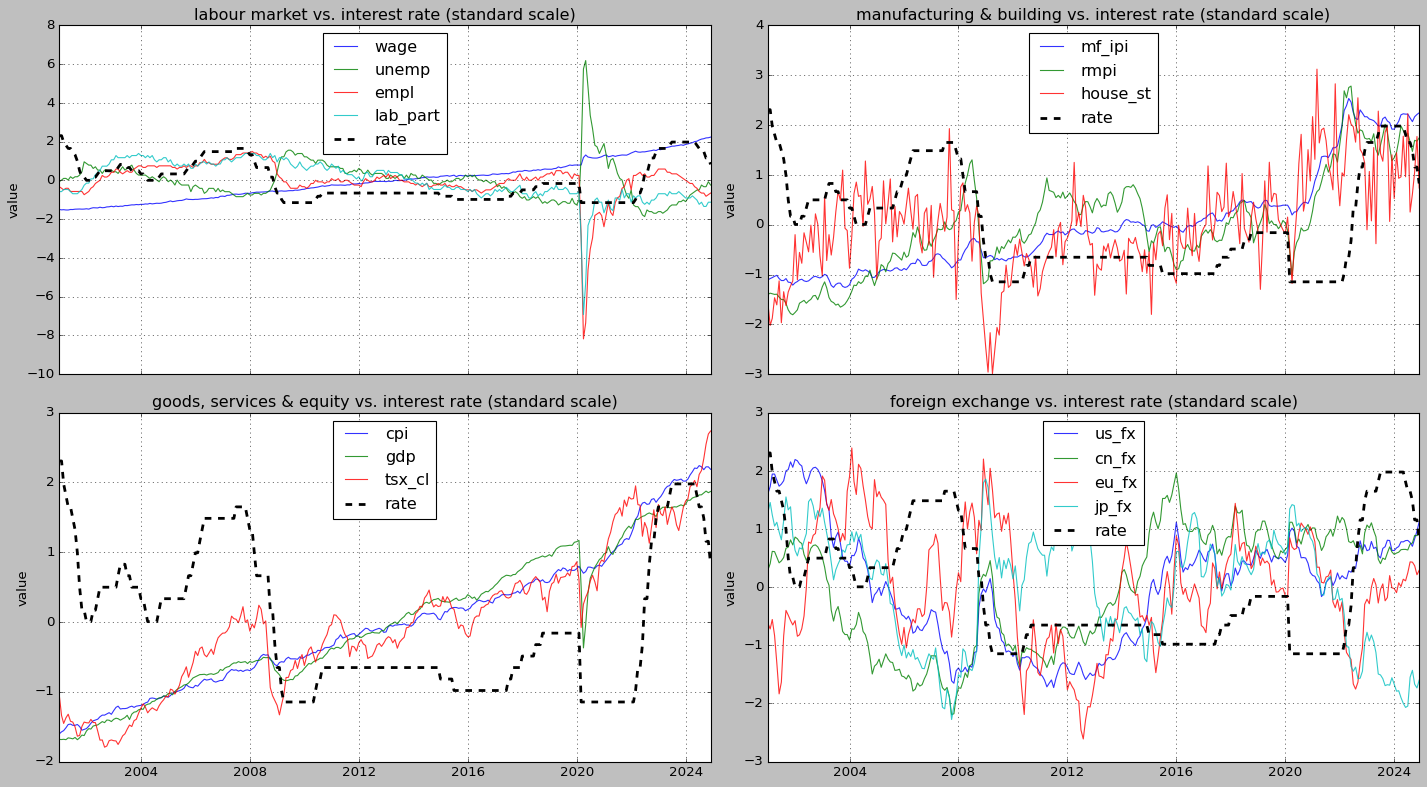

In [26]:
# plt style
plt.style.use('classic')

# groups of vars
labour_vars = ['wage', 'unemp', 'empl', 'lab_part']
mf_vars = ['mf_ipi', 'rmpi', 'house_st']
gs_vars = ['cpi', 'gdp', 'tsx_cl']
fx_vars = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']
groups = {
    'labour market': labour_vars,
    'manufacturing & building': mf_vars,
    'goods, services & equity': gs_vars,
    'foreign exchange': fx_vars
}

# plt groups with rate
fig, axes = plt.subplots(2,
                         2,
                         figsize = (18, 10),
                         sharex = True)
axes = axes.flatten()

for i, (title, vars_) in enumerate(groups.items()):

    ax = axes[i]

    for var in vars_:
        ax.plot(data_scaled['Date'],
                data_scaled[var],
                label = var,
                alpha = 0.8)

    ax.plot(data_scaled['Date'],
            data_scaled['rate'],
            label = 'rate',
            color = 'black',
            linewidth = 2.5,
            linestyle = '--')

    ax.set_title(f'{title} vs. interest rate (standard scale)')
    ax.set_ylabel('value')
    ax.legend(loc = 'upper center')
    ax.grid(True)

plt.xticks()
plt.tight_layout()
plt.show()

Ooof. These plots are terrible. Thankfully this isn't a visualization course. The plots above compare interest rate with groups of features:
* labour market - I think I can see that there appears that the interest rate has bit of a positive correlation with employmentand possibly labour participatin, and a negative correlation with unemployment.
* manufacturing and building - maybe there could be a bit of a positive relationship between the features and interest rate? If one looks at the year 2020, mfg and building features start to increase as the economy pick up in the post-covid period, followed by a sharp rise in the interest rate around 2022-2023 to prevent overheating of the economy. Mfg and building values (to me at least) growth seems to taper off in response.
* goods, service and equity - I feel like theres a positive relationship between the features and interest rate here that would be more apparent if the upward trend component of the data were filtered out. I would have expected to see some apparent relationship with cpi (a common measure of inflation).
* foreign exchange - this is too busy for me to notice many patterns, but maybe the japanese yen exchange rate has a negative relationship with interest rates. Finding the correlations of the features will be needed, and up next.

### 2.2 Correlations

In [27]:
exclude_cols = ['Date', 'rate', 'announcement']
feature_cols = [col for col in data.columns if col not in exclude_cols]

correlation_matrix = data[feature_cols + ['rate']].corr()
rate_correlation = correlation_matrix['rate'].drop(labels = ['rate']).sort_values(ascending = False)

print(rate_correlation)


empl        0.426305
us_fx       0.255054
lab_part    0.200855
house_st    0.161438
eu_fx       0.055311
rmpi        0.050729
mf_ipi      0.048921
tsx_cl      0.007106
cpi        -0.044501
gdp        -0.103649
wage       -0.118164
cn_fx      -0.256279
unemp      -0.458009
jp_fx      -0.503754
Name: rate, dtype: float64


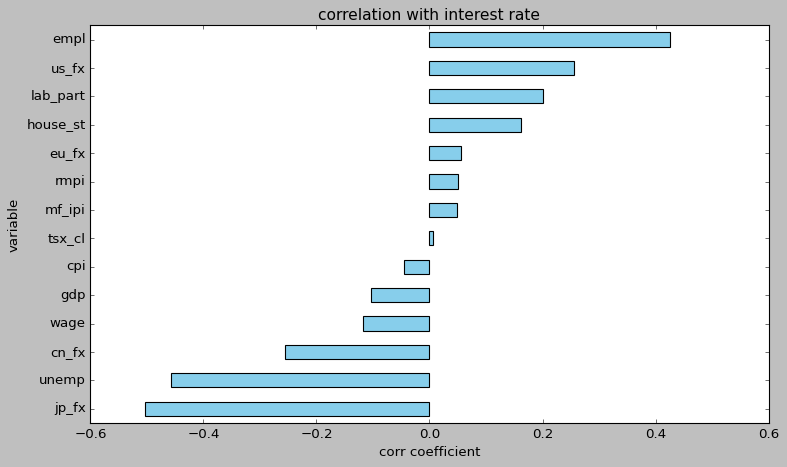

In [28]:
# plt correlations

plt.style.use('classic')

plt.figure(figsize=(10, 6))
rate_correlation.plot(kind = 'barh',
                      color = 'skyblue',
                      edgecolor = 'black')
plt.title('correlation with interest rate',
          fontsize = 14)
plt.xlabel('corr coefficient')
plt.ylabel('variable')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The correlation plot above confirms my thoughts of a positive relationship between interest rate and employment, and the revese with unemployment and japanese yen exchange rate.

Something I found interesting here is that the chinese fx and japanese fx are negatively correlated with the interest rate, but the US fx are positively correlated with the interest rate. Canadian commodities are priced in USD when sold in global markets, interesting to see how the correlations between the currencies differ here.

While some variables show very little correlation with the corresponding interest rate, more patterns will (hopefully) show up when a time series compatible machine learning model is used, and some features are included. The interest rate decisions the central bank makes are rarely based on the current month's data, but on the data from the previous months. It also takes time for effects from changes in something like the raw materials price index and foreign exchange rates to trickle down through the manufacturing sector and into retail sales and the consumer price index. Feature engineering will definitely be required,

## 3 Modeling

My plan for creating models is to start as simply as possible with an RNN, then make additions to it to see how performance improves. I'll then try out some more complex additions such as GRU layers and LSTM layers, and improve upon those.

### 3.1 Feature engineering

In [29]:
ml_df = data.copy()
ml_df = ml_df.reset_index()

The target feature needs to be created, as I have decided to made this a classification problem. Where interest rates hold steady, the class will be 1. Where the rate decreases the class will be 0 and where it increases the class will be 2.

In [30]:
# categorical target creation - rate_change
ml_df['rate_diff'] = ml_df['rate'].diff().fillna(0)
ml_df['rate_change'] = ml_df['rate_diff'].apply(lambda x: 0 if x < 0 else (2 if x > 0 else 1))

ml_df['rate_change'].unique()

array([1, 0, 2])

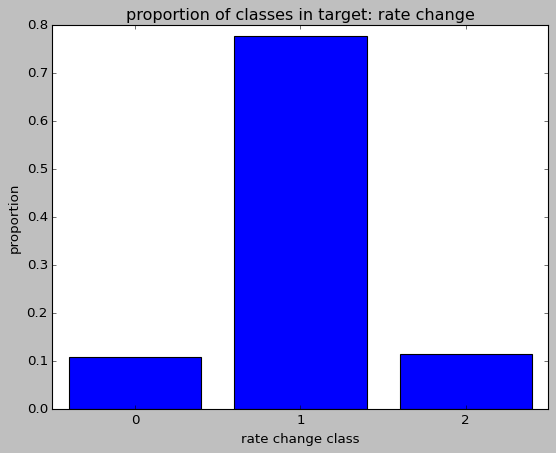

In [31]:
plt.style.use('classic')
# plot class proportions
rate_change_counts = ml_df['rate_change'].value_counts()
proportions = rate_change_counts / len(ml_df)

plt.figure(figsize = (8, 6))
plt.bar(proportions.index,
        proportions.values)
plt.xlabel('rate change class')
plt.ylabel('proportion')
plt.title('proportion of classes in target: rate change')
plt.xticks(proportions.index)
plt.show()

In [32]:
print(proportions)

rate_change
1    0.777778
2    0.114583
0    0.107639
Name: count, dtype: float64


The classes are certainly imbalanced, with 'no change' dominating. Increase and decrease classes look fairly balanced against each other. Imbalanced data will need to be addressed while modeling.

In [33]:
ml_df['Date'] = pd.to_datetime(ml_df['Date'])

* RNN models should be able to pick up lag trends in the data, so I will not add explicit lag features such as 1, 3, 6, and 12 month lags.
* Having a month, quarter, and year indicator can assist in picking up on cyclical trends.

In [34]:
# date features
ml_df['year'] = ml_df['Date'].dt.year
ml_df['month'] = ml_df['Date'].dt.month
ml_df['quarter'] = ml_df['Date'].dt.quarter

The BoC has a target for inflation of 2 % annually (10). Deviations from this target should be a useful feature.

In [35]:
ml_df['cpi_pctchg12'] = ml_df['cpi'].pct_change(periods = 12) * 100  # % inflation over 12 months
ml_df['cpi_dev'] = ml_df['cpi_pctchg12'] - 2.0

In [36]:
# deviation from target inflation rate
ml_df['cpi_target_dev'] = ml_df['cpi'] - 2.0

ml_df['interest_rate_dev_outside_band'] = ml_df['rate'].apply(lambda x: 0 if 1.0 <= x <= 3.0 else (1.0 - x if x < 1.0 else x - 3.0)
 )

In [37]:
ml_df.shape

(288, 27)

Rolling averages, exponentially weight means, rolling standard deviations (measures volatility), trend, and deviations from the trend could also be helpful features.

In [38]:
# function to create features (7)
def create_features(df, feature_list,
                        pct_windows = [1, 3, 12],
                        ema_spans = [3, 6, 9],
                        rolling_std_windows = [3, 6],
                        rolling_mean_windows = [3, 6]):
    '''
    Creates derived features from current features in a df.
    - percent change
    - exponentially weighted mean
    - rolling standard deviation
    - deviations from rolling mean
    - trend deviation
    '''

    df_new = df.copy()
    new_feature_list = []

    for feat in feature_list:
        # percent changeg
        for w in pct_windows:
            colname = f'{feat}_pctchg{w}'
            new_feature_list.append(df_new[feat].pct_change(periods = w)
                                                .rename(colname))

        # EMAs
        for span in ema_spans:
            colname = f'{feat}_ema{span}'
            new_feature_list.append(df_new[feat].ewm(span = span,
                                                     adjust = False)
                                                 .mean()
                                                 .rename(colname))

        # rolling std dev (volatility)
        for w in rolling_std_windows:
            colname = f'{feat}_rolling_std{w}'
            new_feature_list.append(df_new[feat].rolling(window = w)
                                                .std()
                                                .rename(colname))

        # dev from rolling mean
        for w in rolling_mean_windows:
            roll_mean_col = f'{feat}_rolling_mean{w}'
            roll_mean_series = (df_new[feat].rolling(window = w)
                                            .mean()
                                            .rename(roll_mean_col))
            dev_col = f'{feat}_diff_rolling_mean{w}'
            deviation_series = (df_new[feat] - roll_mean_series).rename(dev_col)

            new_feature_list.append(roll_mean_series)
            new_feature_list.append(deviation_series)

        # trend - diff of dev from longest rolling mean
        dev_col_name = f'{feat}_diff_rolling_mean{max(rolling_mean_windows)}'

        # dev from trend
        dev_series = next((s for s in new_feature_list if s.name == dev_col_name), None)
        if dev_series is not None:
             trend_series = dev_series.diff().rename(f'{feat}_trend')
             new_feature_list.append(trend_series)


    # concat new features
    engineered_features = pd.concat(new_feature_list, axis = 1)
    df_new = pd.concat([df_new, engineered_features], axis = 1)

    return df_new

In [39]:
# create new features from list
features_list = ['wage',
                 'rmpi',
                 'cpi',
                 'house_st',
                 'unemp',
                 'empl',
                 'lab_part',
                 'gdp',
                 'mf_ipi',
                 'us_fx',
                 'cn_fx',
                 'eu_fx',
                 'jp_fx',
                 'tsx_cl'
                 ]

In [40]:
ml_df = create_features(ml_df, features_list)

In [41]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Columns: 209 entries, index to tsx_cl_trend
dtypes: datetime64[ns](1), float64(202), int32(3), int64(3)
memory usage: 467.0 KB


Now that lag features have been added, there will be some NA values in the first year of the data. These rows will need to be cut, as RNNs do not handle missing data.

In [42]:
ml_df[ml_df.isna().any(axis = 1)]

,index,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,...,tsx_cl_ema3,tsx_cl_ema6,tsx_cl_ema9,tsx_cl_rolling_std3,tsx_cl_rolling_std6,tsx_cl_rolling_mean3,tsx_cl_diff_rolling_mean3,tsx_cl_rolling_mean6,tsx_cl_diff_rolling_mean6,tsx_cl_trend
0,0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,...,9321.870000,9321.870000,9321.870000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,...,8700.295000,8966.684286,9073.240000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2001-03-01,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,...,8154.147500,8578.488776,8780.192000,885.470649,NaN,8336.196667,-728.196667,NaN,NaN,NaN
3,3,2001-04-01,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,...,8050.388750,8397.957697,8613.479600,242.794619,NaN,7877.783333,68.846667,NaN,NaN,NaN
4,4,2001-05-01,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,...,8106.129375,8330.504069,8523.157680,279.216317,NaN,7905.500000,256.370000,NaN,NaN,NaN
5,5,2001-06-01,656.81,63.9,98.7,155.286,7.2,61.1,65.9,1438295.0,...,7921.239688,8160.745764,8365.796144,212.764818,613.900547,7948.283333,-211.933333,8142.240000,-405.890000,NaN
6,6,2001-07-01,656.43,62.7,98.4,128.469,7.1,61.1,65.8,1436172.0,...,7805.464844,8026.158403,8230.574915,260.191717,225.229681,7862.636667,-172.946667,7870.210000,-180.520000,225.370000
7,7,2001-08-01,659.47,62.7,98.4,148.331,7.2,61.1,65.8,1440974.0,...,7602.342422,7847.033145,8064.303932,182.668467,266.474701,7608.420000,-209.200000,7756.960000,-357.740000,-177.220000
8,8,2001-09-01,659.90,60.8,98.6,139.504,7.2,61.1,65.8,1433233.0,...,7220.451211,7558.897961,7819.155146,432.653582,464.250002,7309.156667,-470.596667,7628.720000,-790.160000,-432.420000
9,9,2001-10-01,660.91,57.7,98.1,148.167,7.3,61.1,65.9,1439780.0,...,7053.075605,7366.555686,7632.464117,310.983549,517.891275,7041.160000,-155.460000,7451.898333,-566.198333,223.961667


In [43]:
ml_df = ml_df.dropna()

In [44]:
ml_df.drop(columns = 'index',
           inplace = True)


ml_df.head(2)

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,...,tsx_cl_ema3,tsx_cl_ema6,tsx_cl_ema9,tsx_cl_rolling_std3,tsx_cl_rolling_std6,tsx_cl_rolling_mean3,tsx_cl_diff_rolling_mean3,tsx_cl_rolling_mean6,tsx_cl_diff_rolling_mean6,tsx_cl_trend
12,2002-01-01,663.15,56.4,97.6,184.910,8.0,61.0,66.3,1463177.0,76.2,...,7556.188201,7521.407233,7618.148428,141.594544,369.128155,7587.516667,60.973333,7314.338333,334.151667,-33.053333
13,2002-02-01,659.88,57.7,98.2,155.942,7.9,61.1,66.3,1471175.0,76.6,...,7596.844100,7554.576595,7622.018742,26.789969,392.184561,7658.133333,-20.633333,7354.051667,283.448333,-50.703333


In [53]:
ml_df[['rate_change']]

,rate_change
12,0
13,1
14,1
15,2
16,1
...,...
283,1
284,0
285,0
286,1


### 3.2 Labels, sequencing, and class imbalance

Next, the data needed to be labeled, split and turned into sequences for the models to process.

In [56]:
# prep features
X = ml_df.drop(columns = ['rate', 'rate_change'])
X = X.select_dtypes(exclude = ['datetime64[ns]',
                               'datetime64[ns, UTC]'])
y = ml_df['rate_change']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split data
split_point = int(len(X_scaled) * 0.8)
X_train = X_scaled[:split_point]
X_test  = X_scaled[split_point:]

y_train = y[:split_point]
y_test  = y[split_point:]

y_train_labels = y_train.to_numpy()

# encode target
y_train = to_categorical(y_train_labels,
                         num_classes = 3)
y_test  = to_categorical(y_test.to_numpy(),
                         num_classes = 3)

In [57]:
# create sequences
def create_sequences(X, y, time_steps = 12):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])

        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train,
                                            y_train,
                                            time_steps)
X_test_seq, y_test_seq = create_sequences(X_test,
                                          y_test,
                                          time_steps)

print('X_train_seq shape:', X_train_seq.shape)
print('y_train_seq shape:', y_train_seq.shape)

X_train_seq shape: (208, 12, 205)
y_train_seq shape: (208, 3)


In [58]:
 # imbalanced class weights
weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(y_train_labels),
                                            y = y_train_labels)

weights = np.clip(weights, 0.5, 2.0)

class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(2.0), 1: np.float64(0.5), 2: np.float64(2.0)}


In [59]:
# function to plot histories - going to be doing a lot of these

def plot_history(history):
    plt.figure(figsize = (12, 4))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],
             label = 'train acc')
    plt.plot(history.history['val_accuracy'],
             label = 'val acc')
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],
             label = 'train loss')
    plt.plot(history.history['val_loss'],
             label = 'val loss')
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### 3.3 Vanilla RNN models

In [60]:
# reproducibility
random.seed(5511)

#### 3.3.1 Simple RNN

Vanilla RNNs are limited in their memory capacity as the sequences in the data become longer. The first model I tried is very basic, just to get started. It has a single lstm layer with 64 units (tp capture low-level sequential features), followed by a dropout layer (prevents overfitting), fully connected/dense layer, and then an output layer (3 units with softmax activation because there are 3 classes to this multiclass prediction).

In [61]:
K.clear_session()

optimizer = Adam(learning_rate = 0.001)

rnn1 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    SimpleRNN(64, return_sequences = False,
              activation = 'tanh'),
    Dropout(0.3),

    Dense(32, activation = 'relu'),
    Dropout(0.3),

    Dense(3, activation = 'softmax')


])

rnn1.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

rnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,459 (76.01 KB)

 Trainable params: 19,459 (76.01 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history_rnn1 = rnn1.fit(X_train_seq,
                        y_train_seq,
                        epochs = 10,
                        batch_size = 32,
                        validation_data = (X_test_seq,
                                           y_test_seq),
                        class_weight = class_weights,
                        verbose = 0)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.1466 - loss: 1.3669 - val_accuracy: 0.2045 - val_loss: 1.9502
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2901 - loss: 0.8767 - val_accuracy: 0.2045 - val_loss: 2.1171
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4763 - loss: 0.7754 - val_accuracy: 0.2045 - val_loss: 2.3059
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5785 - loss: 0.6602 - val_accuracy: 0.2273 - val_loss: 2.5690
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6293 - loss: 0.6287 - val_accuracy: 0.2273 - val_loss: 2.9510
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6974 - loss: 0.5324 - val_accuracy: 0.2273 - val_loss: 3.2125
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7190 - loss: 0.5673 - val_accuracy: 0.2273 - val_loss: 3.2378
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7575 - loss: 0.4675 - val_accuracy: 0.2273 - val_loss: 3.4563

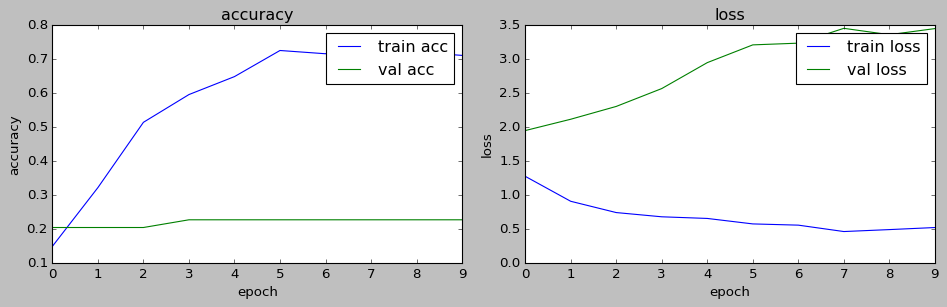

In [63]:
plot_history(history_rnn1)

That model didn't work very well at all, definitely overfitting, and needs some additions.

#### 3.3.2 Stacked RNN with layer normalization

For the next model, I added:
* Another RNN layer - 64 units, and then 32 units. Adding layers gradually compressing the data reduces dimensionality in steps. It helps with overfitting, and encourages the neural network to extract the more important features.  
* Layer normalization after each rnn layer, so that normalization is consistent across features in each time step.  
* Dense layer unit increased to 64. This allows for more detailed encoding of the features into the dense layer tp improve classification performance.

In [64]:
K.clear_session()

optimizer = Adam(learning_rate = 0.001)

rnn2 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    SimpleRNN(64, return_sequences = True,
              activation = 'tanh'),
    LayerNormalization(),
    Dropout(0.3),

    SimpleRNN(32, return_sequences = False,
              activation = 'tanh'),
    LayerNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.3),

    Dense(3, activation = 'softmax')


])

rnn2.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

rnn2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12, 64)         │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 12, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,883 (89.39 KB)

 Trainable params: 22,883 (89.39 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history_rnn2 = rnn2.fit(X_train_seq,
                        y_train_seq,
                        epochs = 20,
                        batch_size = 32,
                        validation_data = (X_test_seq,
                                           y_test_seq),
                        class_weight = class_weights,
                        verbose = 0)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.4685 - loss: 1.0329 - val_accuracy: 0.5455 - val_loss: 1.0082
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5651 - loss: 0.8661 - val_accuracy: 0.6136 - val_loss: 0.9451
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6416 - loss: 0.7969 - val_accuracy: 0.6364 - val_loss: 0.9205
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7201 - loss: 0.6539 - val_accuracy: 0.6591 - val_loss: 0.9161
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7505 - loss: 0.6349 - val_accuracy: 0.6591 - val_loss: 0.9015
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7122 - loss: 0.7245 - val_accuracy: 0.6591 - val_loss: 0.8923
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7024 - loss: 0.6703 - val_accuracy: 0.6591 - val_loss: 0.8949
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6691 - loss: 0.7561 - val_accuracy: 0.6591 - val_loss: 0.9145

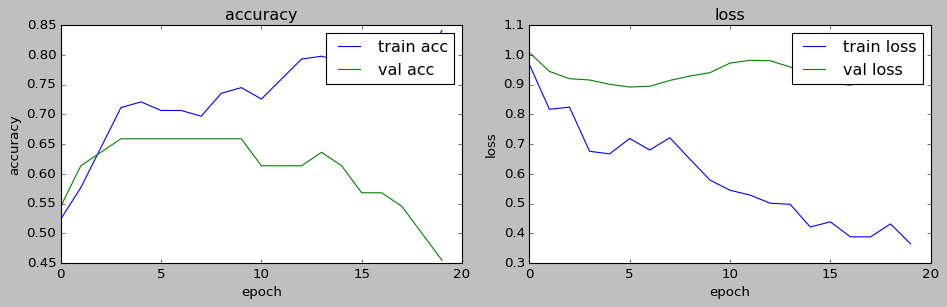

In [66]:
plot_history(history_rnn2)

#### 3.3.3 Stacked bidirectional RNN with batch normalization

Here I added a bidirectional layer to capture patterns from the past and future sequences to pick up on more time-related patterns. At this point, batch normalization seemed to work better than layer normalization. If batch normalization is applied outside of the RNN cell, it should iavoid interfering with time dependencies.

In [67]:
K.clear_session()

optimizer = Adam(learning_rate = 0.001)

rnn3 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    Bidirectional(SimpleRNN(64, return_sequences = True,
                  activation = 'tanh')),
    BatchNormalization(),
    Dropout(0.3),

    SimpleRNN(32, return_sequences = False,
              activation = 'tanh'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.3),

    Dense(3, activation = 'softmax')


])

rnn3.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

rnn3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,659 (166.64 KB)

 Trainable params: 42,339 (165.39 KB)

 Non-trainable params: 320 (1.25 KB)

In [69]:
history_rnn3 = rnn3.fit(X_train_seq,
                        y_train_seq,
                        epochs = 10,
                        batch_size = 32,
                        validation_data = (X_test_seq,
                                           y_test_seq),
                        class_weight = class_weights,
                        verbose = 0)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.4178 - loss: 1.0695 - val_accuracy: 0.5000 - val_loss: 1.0200
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5289 - loss: 0.7643 - val_accuracy: 0.6591 - val_loss: 0.9181
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 0.7260 - val_accuracy: 0.6364 - val_loss: 0.8921
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5896 - loss: 0.6613 - val_accuracy: 0.6591 - val_loss: 0.9142
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7219 - loss: 0.4875 - val_accuracy: 0.6591 - val_loss: 0.9310
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6507 - loss: 0.5989 - val_accuracy: 0.6136 - val_loss: 0.9376
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7395 - loss: 0.5698 - val_accuracy: 0.5682 - val_loss: 0.9399
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7467 - loss: 0.5349 - val_accuracy: 0.5682 - val_loss: 0.954

#### 3.3.4 Stacked bidirectional RNN, batch normalization, and  more depth

I added more depth to the next model, starting 128 units in the bidirectional layer, then 64, then 32 units. A larger number of units expands the initial scope for patterns, and allows gradual compression of information and hopefully continues to encourage the model to extract the more important features.

In [72]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

rnn4 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    Bidirectional(SimpleRNN(128, return_sequences = True,
              activation = 'tanh')),
    BatchNormalization(),
    Dropout(0.3),

    SimpleRNN(64, return_sequences = True,
              activation = 'tanh'),
    BatchNormalization(),
    Dropout(0.3),

    SimpleRNN(32, return_sequences = False,
              activation = 'tanh'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.3),

    Dense(3, activation = 'softmax')


])

rnn4.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

rnn4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 256)        │        85,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 12, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,867 (440.89 KB)

 Trainable params: 112,163 (438.14 KB)

 Non-trainable params: 704 (2.75 KB)

In [73]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

history_rnn4 = rnn4.fit(X_train_seq,
                          y_train_seq,
                          epochs = 30,
                          batch_size = 32,
                          validation_data = (X_test_seq,
                                             y_test_seq),
                          class_weight = class_weights,
                          callbacks = [early_stop],
                          verbose = 0)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.2007 - loss: 1.1729 - val_accuracy: 0.2273 - val_loss: 1.1866
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2033 - loss: 1.0608 - val_accuracy: 0.5227 - val_loss: 1.0813
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2803 - loss: 1.0536 - val_accuracy: 0.6364 - val_loss: 1.0198
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3622 - loss: 0.8842 - val_accuracy: 0.6364 - val_loss: 0.9837
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3607 - loss: 1.0061 - val_accuracy: 0.6364 - val_loss: 0.9782
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4274 - loss: 0.9253 - val_accuracy: 0.6364 - val_loss: 0.9652
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4331 - loss: 0.8760 - val_accuracy: 0.6364 - val_loss: 0.9529
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5024 - loss: 0.8241 - val_accuracy: 0.6364 - val_loss: 0.945

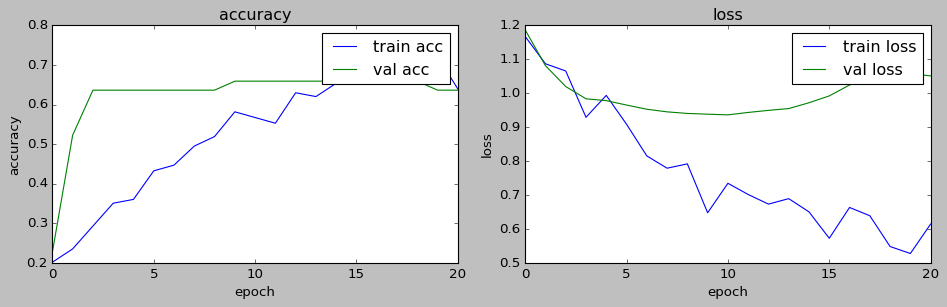

In [74]:
plot_history(history_rnn4)

###  3.4 GRU models

Gated Recurrent Unit, or GRU, models are a type of RNN designed to capture dependencies in time series data. They are a little more complex than a vanilla rnn and combine the input and forget gates into an update gate. They can handle longer sequences than RNNs. I'll follow the same process as I did for the vanilla RNNs above - start basic and add more to each model.

#### 3.4.1 Basic GRU

In [75]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

gru1 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    GRU(64, return_sequences = False),
    Dropout(0.3),

    Dense(32, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')
])

gru1.compile(loss = 'categorical_crossentropy',
                   optimizer = optimizer,
                   metrics = ['accuracy'])

gru1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        52,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,211 (211.76 KB)

 Trainable params: 54,211 (211.76 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

history_gru1 = gru1.fit(X_train_seq,
                            y_train_seq,
                            epochs = 50,
                            batch_size = 32,
                            validation_data = (X_test_seq,
                                               y_test_seq),
                            class_weight = class_weights,
                            callbacks = [early_stop],
                            verbose = 0)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.3277 - loss: 0.9269 - val_accuracy: 0.1136 - val_loss: 1.8730
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4991 - loss: 0.7790 - val_accuracy: 0.1591 - val_loss: 1.9533
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5496 - loss: 0.7506 - val_accuracy: 0.1591 - val_loss: 1.8931
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5587 - loss: 0.6923 - val_accuracy: 0.1591 - val_loss: 1.8421
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5957 - loss: 0.6623 - val_accuracy: 0.1818 - val_loss: 1.7542
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6745 - loss: 0.6245 - val_accuracy: 0.1818 - val_loss: 1.6905
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6891 - loss: 0.6016 - val_accuracy: 0.2273 - val_loss: 1.7227
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7573 - loss: 0.5700 - val_accuracy: 0.2273 - val_loss: 1.7533


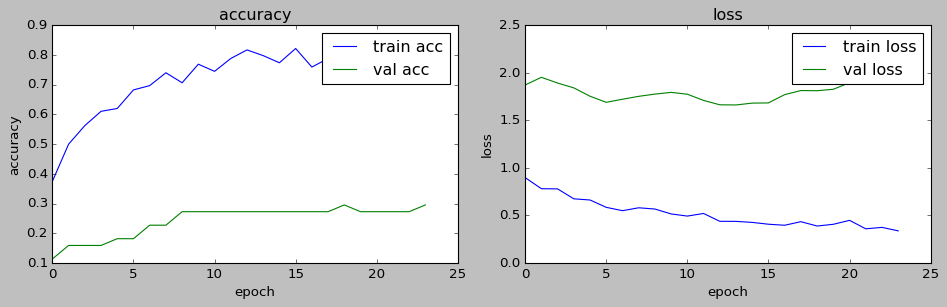

In [77]:
plot_history(history_gru1)

#### 3.4.2 Stacked GRU with batch normalization

Similar to the RNN modeling, when more depth is added, batch normalization worked a bit better than layer normalization. I implemented reducing the learning rate on plateau to improve training stability.

In [78]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

gru2 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    GRU(64, return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),

    GRU(32, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')
])

gru2.compile(loss = 'categorical_crossentropy',
                   optimizer = optimizer,
                   metrics = ['accuracy'])

gru2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 64)         │        52,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,979 (246.01 KB)

 Trainable params: 62,787 (245.26 KB)

 Non-trainable params: 192 (768.00 B)

In [79]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)

history_gru2 = gru2.fit(X_train_seq,
                            y_train_seq,
                            epochs = 50,
                            batch_size = 32,
                            validation_data = (X_test_seq,
                                               y_test_seq),
                            class_weight = class_weights,
                            callbacks = [early_stop,
                                         reduce_lr],
                            verbose = 0)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.4475 - loss: 1.0428 - val_accuracy: 0.3636 - val_loss: 1.1003 - learning_rate: 5.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4874 - loss: 0.9120 - val_accuracy: 0.4545 - val_loss: 1.0837 - learning_rate: 5.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4908 - loss: 0.9017 - val_accuracy: 0.4773 - val_loss: 1.0494 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4400 - loss: 0.8637 - val_accuracy: 0.4773 - val_loss: 1.0350 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5304 - loss: 0.7804 - val_accuracy: 0.4773 - val_loss: 1.0267 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4819 - loss: 0.8403 - val_accuracy: 0.4773 - val_loss: 1.0109 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5844 - loss: 0.72

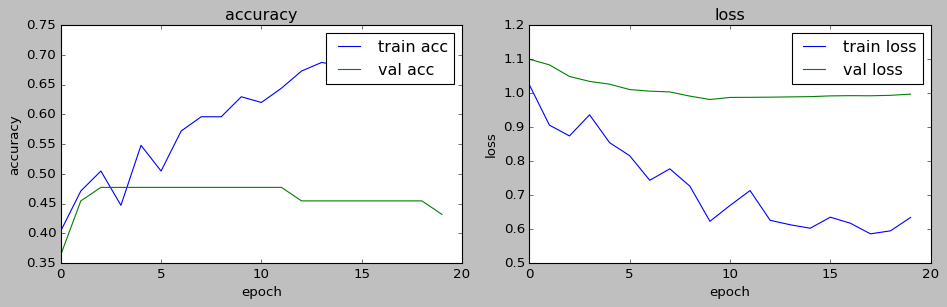

In [80]:
plot_history(history_gru2)

#### 3.4.3 Stacked bidirectional GRU with batch normalization

Similar to the RNN modeling, when more depth is added, batch normalization worked a bit better than layer normalization.

In [81]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

gru3 = Sequential([
    Input(shape=(X_train_seq.shape[1],
                 X_train_seq.shape[2])),

    Bidirectional(GRU(64, return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    GRU(32, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')
])

gru3.compile(loss = 'categorical_crossentropy',
                    optimizer = optimizer,
                    metrics = ['accuracy'])

gru3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │       104,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,411 (474.26 KB)

 Trainable params: 121,091 (473.01 KB)

 Non-trainable params: 320 (1.25 KB)

In [82]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)

history_gru3 = gru3.fit(X_train_seq,
                              y_train_seq,
                              epochs = 50,
                              batch_size = 32,
                              validation_data = (X_test_seq,
                                                 y_test_seq),
                              class_weight = class_weights,
                              callbacks = [early_stop,
                                           reduce_lr],
                              verbose = 0)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.5835 - loss: 0.9312 - val_accuracy: 0.6136 - val_loss: 0.9844 - learning_rate: 5.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5880 - loss: 0.9434 - val_accuracy: 0.6136 - val_loss: 0.9625 - learning_rate: 5.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7249 - loss: 0.7092 - val_accuracy: 0.6364 - val_loss: 0.9242 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6586 - loss: 0.7741 - val_accuracy: 0.6364 - val_loss: 0.9066 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6853 - loss: 0.6909 - val_accuracy: 0.6364 - val_loss: 0.8972 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6236 - loss: 0.6701 - val_accuracy: 0.6364 - val_loss: 0.8965 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6410 - loss: 0.68

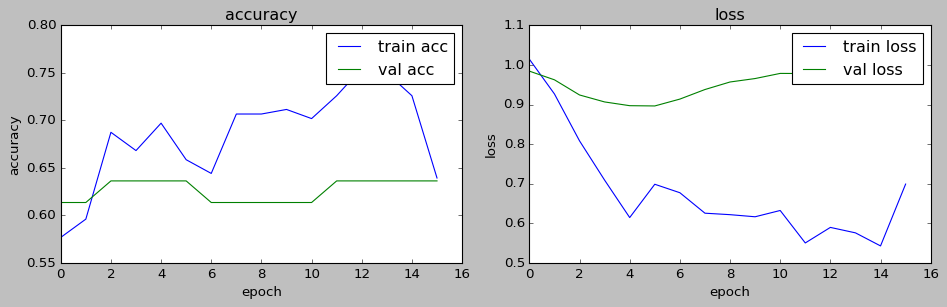

In [83]:
plot_history(history_gru3)

#### 3.4.4 Stacked bidirectional GRU, batch normalization, and more depth

In [113]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

gru4 = Sequential([
    Input(shape=(X_train_seq.shape[1],
                 X_train_seq.shape[2])),

    Bidirectional(GRU(128, return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    GRU(64, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')
])

gru4.compile(loss = 'categorical_crossentropy',
                    optimizer = optimizer,
                    metrics = ['accuracy'])

gru4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 256)        │       257,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,739 (1.24 MB)

 Trainable params: 324,099 (1.24 MB)

 Non-trainable params: 640 (2.50 KB)

In [114]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1)

history_gru4 = gru4.fit(X_train_seq,
                              y_train_seq,
                              epochs = 50,
                              batch_size = 32,
                              validation_data = (X_test_seq,
                                                 y_test_seq),
                              class_weight = class_weights,
                              callbacks = [early_stop,
                                           reduce_lr],
                              verbose = 0)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.1541 - loss: 1.3662 - val_accuracy: 0.5000 - val_loss: 1.0455 - learning_rate: 5.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.2927 - loss: 1.0213 - val_accuracy: 0.6591 - val_loss: 0.9384 - learning_rate: 5.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3346 - loss: 0.9485 - val_accuracy: 0.6591 - val_loss: 0.8834 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4910 - loss: 0.8078 - val_accuracy: 0.6591 - val_loss: 0.8595 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5097 - loss: 0.7586 - val_accuracy: 0.6591 - val_loss: 0.8406 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5906 - loss: 0.6029 - val_accuracy: 0.6591 - val_loss: 0.8235 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5767 - loss: 0.6

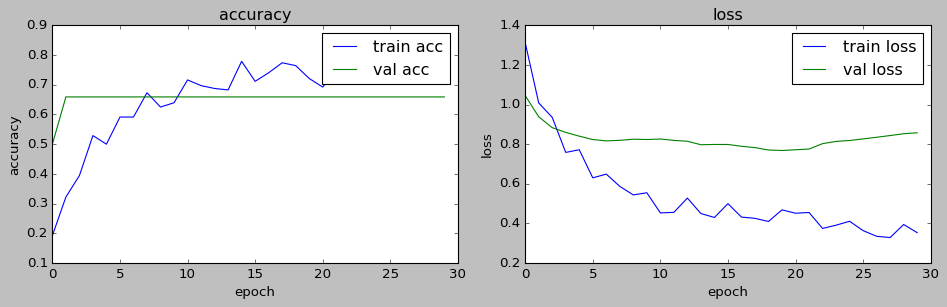

In [116]:
plot_history(history_gru4)

### 3.5 LSTM models

LSTM models have memory cells with input, forget, and output gates. They are more complex than a GRU and better at handling long-term dependencies. Because they are more complex, LSTMs require more resources than GRUs and RNNs. Here I follow the same pattern as I did for RNN and GRU modeling of starting basic and adding to the model at each step.

#### 3.5.1 Basic LSTM model

I started with a single lstm layer with 64 units tp capture low-level sequential features.

In [89]:
K.clear_session()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                     clipnorm = 1.0)

lstm1 = Sequential([Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    LSTM(64, return_sequences = False),
    Dropout(0.2),

    Dense(32, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

# compile
lstm1.compile(loss = 'categorical_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])

lstm1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,299 (278.51 KB)

 Trainable params: 71,299 (278.51 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 5,
                           restore_best_weights = True)

history_lstm1 = lstm1.fit(X_train_seq,
                      y_train_seq,
                      epochs = 30,
                      batch_size = 16,
                      validation_data = (X_test_seq,
                                         y_test_seq),
                      class_weight = class_weights,
                      callbacks = [early_stop],
                      verbose = 0)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.4231 - loss: 0.9004 - val_accuracy: 0.4545 - val_loss: 1.1144
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7666 - loss: 0.6271 - val_accuracy: 0.2955 - val_loss: 1.1140
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7782 - loss: 0.5134 - val_accuracy: 0.2273 - val_loss: 1.1370
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8274 - loss: 0.4652 - val_accuracy: 0.1364 - val_loss: 1.1505
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8605 - loss: 0.3677 - val_accuracy: 0.1136 - val_loss: 1.1917
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8455 - loss: 0.3161 - val_accuracy: 0.1364 - val_loss: 1.1997
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8638 - loss: 0.3127 - val_accuracy: 0.1364 - val_loss: 1.2400


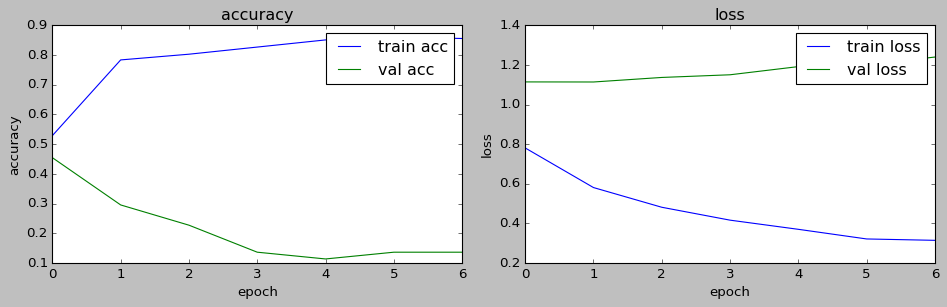

In [91]:
plot_history(history_lstm1)

Overfitting here...

#### 3.5.2 Stacked LSTM with batch normalization

In [92]:
K.clear_session()

lstm2 = Sequential([Input(shape = (X_train_seq.shape[1],
                                    X_train_seq.shape[2])),

    LSTM(64, return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.4),
    Dense(3, activation = 'softmax')])

lstm2.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

lstm2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,227 (329.01 KB)

 Trainable params: 84,035 (328.26 KB)

 Non-trainable params: 192 (768.00 B)

In [93]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 5,
                           restore_best_weights = True)

history_lstm2 = lstm2.fit(X_train_seq,
                      y_train_seq,
                      epochs = 30,
                      batch_size = 16,
                      validation_data = (X_test_seq,
                                         y_test_seq),
                      class_weight = class_weights,
                      callbacks = [early_stop],
                      verbose = 0)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.2435 - loss: 1.1540 - val_accuracy: 0.5455 - val_loss: 1.0528
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3827 - loss: 1.0056 - val_accuracy: 0.6591 - val_loss: 0.9815
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5230 - loss: 0.8556 - val_accuracy: 0.6591 - val_loss: 0.9561
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5497 - loss: 0.8069 - val_accuracy: 0.6591 - val_loss: 0.9375
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6171 - loss: 0.7333 - val_accuracy: 0.6591 - val_loss: 0.9417
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6770 - loss: 0.5430 - val_accuracy: 0.6591 - val_loss: 0.9052
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6816 - loss: 0.6142 - val_accuracy: 0.6591 - val_loss: 0.9149
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6215 - loss: 0.6073 - val_accuracy: 0.6591 - v

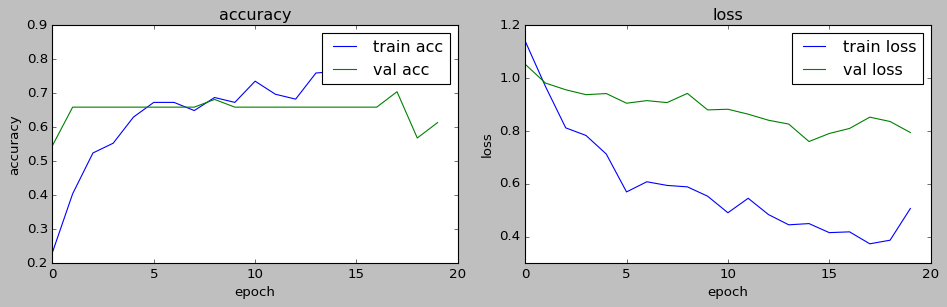

In [94]:
plot_history(history_lstm2)

Model 2 is an improvement over model 1, hitting a training ceiling at 0.6591 validation accuracy.

#### 3.5.3 Stacked bidirectional LSTM, batch normalization, more depth

The next model uses 128 units in the bidirectional lstm model - this expands the initial scope for patterns. By narrowing down the number of lstm units in each layer, the information is gradually being compressed to extract finer features at each stage.

In [95]:
K.clear_session()

lstm3 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),

    Bidirectional(LSTM(64, return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.4),
    Dense(3, activation = 'softmax')])

lstm3.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

lstm3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │       138,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,795 (632.01 KB)

 Trainable params: 161,475 (630.76 KB)

 Non-trainable params: 320 (1.25 KB)

In [96]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

history_lstm3 = lstm3.fit(X_train_seq,
                      y_train_seq,
                      epochs = 50,
                      batch_size = 16,
                      validation_data = (X_test_seq,
                                         y_test_seq),
                      class_weight = class_weights,
                      callbacks=[early_stop],
                      verbose = 0)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.3657 - loss: 0.9940 - val_accuracy: 0.3636 - val_loss: 1.0729
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5031 - loss: 0.7796 - val_accuracy: 0.6591 - val_loss: 1.0203
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5770 - loss: 0.7134 - val_accuracy: 0.6591 - val_loss: 0.9575
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6306 - loss: 0.6852 - val_accuracy: 0.6591 - val_loss: 0.9454
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6553 - loss: 0.6655 - val_accuracy: 0.6591 - val_loss: 0.9254
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7226 - loss: 0.5351 - val_accuracy: 0.6591 - val_loss: 0.9208
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7356 - loss: 0.5304 - val_accuracy: 0.6364 - val_loss: 0.9020
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7392 - loss: 0.4614 - val_accuracy: 0.6364 - 

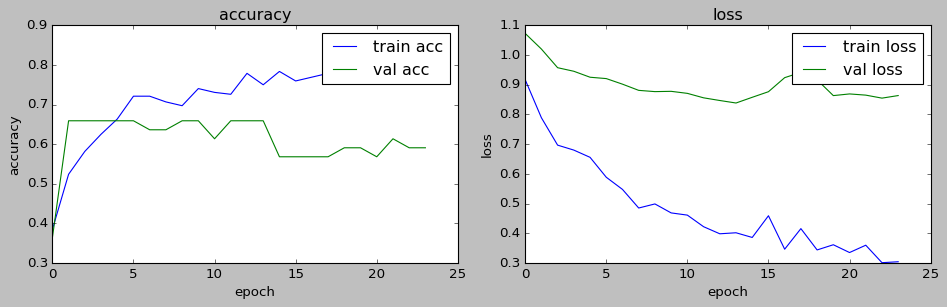

In [97]:
plot_history(history_lstm3)

For model 3 i increased the patience to 10 and added more epochs, but still stopping at 13 epochs. model is likely predicting majority class.

#### 3.5.4 Stacked bidirectional LSTM, batch normalization balanced and little deeper

The fully connected layer units was increased to allow for more detailed encoding the features into the dense layer in the hopes it would improve classification performance.

I implemented reducing the learning rate on plateau to improve training stability.

In [100]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

lstm4 = Sequential([Input(shape = (X_train_seq.shape[1],
                                    X_train_seq.shape[2])),

    Bidirectional(LSTM(128, return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')])

lstm4.compile(loss = 'categorical_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])

lstm4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 256)        │       342,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,107 (1.77 MB)

 Trainable params: 462,339 (1.76 MB)

 Non-trainable params: 768 (3.00 KB)

In [101]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)

history_lstm4 = lstm4.fit(X_train_seq,
                      y_train_seq,
                      epochs = 50,
                      batch_size = 32,
                      validation_data = (X_test_seq,
                                         y_test_seq),
                      class_weight = class_weights,
                      callbacks = [early_stop,
                                   reduce_lr],
                      verbose = 0)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.3104 - loss: 1.1310 - val_accuracy: 0.6591 - val_loss: 1.0316 - learning_rate: 5.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5314 - loss: 0.7265 - val_accuracy: 0.6591 - val_loss: 1.0142 - learning_rate: 5.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4806 - loss: 0.9190 - val_accuracy: 0.6591 - val_loss: 1.0004 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4835 - loss: 0.8024 - val_accuracy: 0.6591 - val_loss: 0.9856 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6324 - loss: 0.6566 - val_accuracy: 0.6591 - val_loss: 0.9674 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6610 - loss: 0.5185 - val_accuracy: 0.6591 - val_loss: 0.9495 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6893 - loss: 0.5

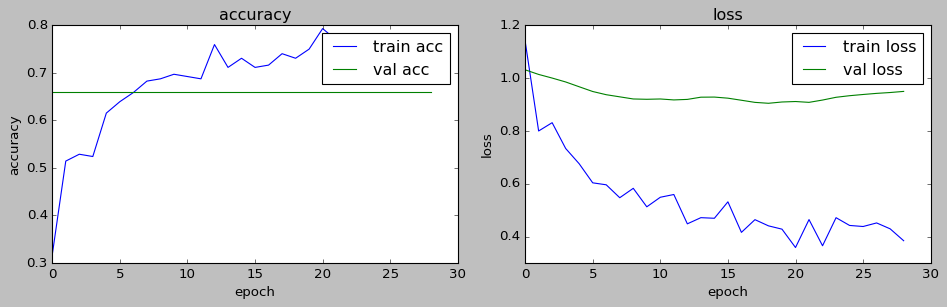

In [102]:
plot_history(history_lstm4)

Model 4 is hitting the training ceiling more than model 3. If my data weren't limited, I susperct that it would perform better than model 3.

### 3.6 Combined models

I did some reading, and turns out that different types of layers can be combined. Here I will try out a GRU 128, LSTM 64, and RNN 32 architecture.

#### 3.6.1 Stacked bidirectional GRU-LSTM-RNN

In [118]:
K.clear_session()

optimizer = Adam(learning_rate=0.0005)

combined1 = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),

    Bidirectional(GRU(128, return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),

    SimpleRNN(32, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')
])

combined1.compile(loss='categorical_crossentropy',
                       optimizer = optimizer,
                       metrics = ['accuracy'])

combined1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 256)        │       257,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,275 (1.32 MB)

 Trainable params: 345,571 (1.32 MB)

 Non-trainable params: 704 (2.75 KB)

In [119]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)

history_combined1 = combined1.fit(X_train_seq,
                          y_train_seq,
                          epochs = 100,
                          batch_size = 32,
                          validation_data = (X_test_seq,
                                             y_test_seq),
                          class_weight = class_weights,
                          callbacks = [early_stop,
                                     reduce_lr],
                          verbose = 0)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.3933 - loss: 1.0859 - val_accuracy: 0.3636 - val_loss: 1.1446 - learning_rate: 5.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5168 - loss: 0.8391 - val_accuracy: 0.3864 - val_loss: 1.1424 - learning_rate: 5.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5012 - loss: 0.8885 - val_accuracy: 0.3864 - val_loss: 1.1147 - learning_rate: 5.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5453 - loss: 0.7667 - val_accuracy: 0.4091 - val_loss: 1.0911 - learning_rate: 5.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6193 - loss: 0.6696 - val_accuracy: 0.3864 - val_loss: 1.0754 - learning_rate: 5.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6471 - loss: 0.7442 - val_accuracy: 0.4091 - val_loss: 1.0626 - learning_rate: 5.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6472 - los

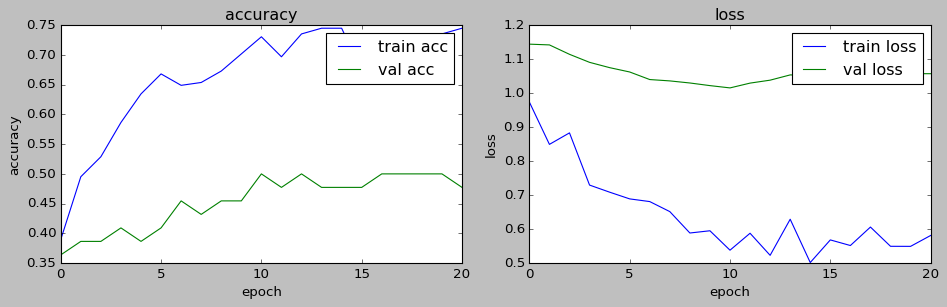

In [120]:
plot_history(history_combined1)

#### 3.6.2 Stacked LSTM-GRU-RNN bidirectional

In [106]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

combined2 = Sequential([
    Input(shape=(X_train_seq.shape[1],
                 X_train_seq.shape[2])),

    Bidirectional(LSTM(128, return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    GRU(64, return_sequences = False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')
])

combined2.compile(loss = 'categorical_crossentropy',
                       optimizer = optimizer,
                       metrics = ['accuracy'])

combined2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 256)        │       342,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,475 (1.56 MB)

 Trainable params: 408,835 (1.56 MB)

 Non-trainable params: 640 (2.50 KB)

In [107]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)

history_combined2 = combined2.fit(X_train_seq,
                                  y_train_seq,
                                  epochs = 100,
                                  batch_size = 32,
                                  validation_data = (X_test_seq, y_test_seq),
                                  class_weight = class_weights,
                                  callbacks=[early_stop,
                                             reduce_lr],
                                  verbose = 0)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.1942 - loss: 1.4679 - val_accuracy: 0.2955 - val_loss: 1.0898 - learning_rate: 5.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2675 - loss: 1.0765 - val_accuracy: 0.4091 - val_loss: 1.0385 - learning_rate: 5.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4396 - loss: 0.8653 - val_accuracy: 0.5455 - val_loss: 1.0049 - learning_rate: 5.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4574 - loss: 0.6954 - val_accuracy: 0.5227 - val_loss: 0.9992 - learning_rate: 5.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5603 - loss: 0.6418 - val_accuracy: 0.6136 - val_loss: 0.9880 - learning_rate: 5.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6105 - loss: 0.5444 - val_accuracy: 0.6591 - val_loss: 0.9625 - learning_rate: 5.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5573 - los

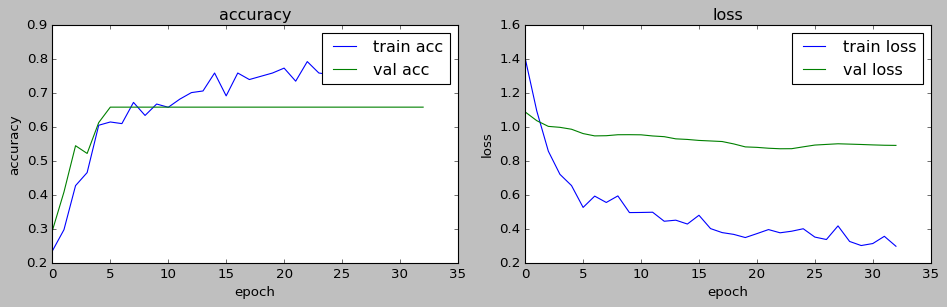

In [108]:
plot_history(history_combined2)

In [123]:
# display histories

histories = {
    'rnn1': history_rnn1,
    'rnn2': history_rnn2,
    'rnn3': history_rnn3,
    'rnn4': history_rnn4,
    'gru1': history_gru1,
    'gru2': history_gru2,
    'gru3': history_gru3,
    'gru4': history_gru4,
    'lstm1': history_lstm1,
    'lstm2': history_lstm2,
    'lstm3': history_lstm3,
    'lstm4': history_lstm4,
    'combined1': history_combined1,
    'combined2': history_combined2
}

model_losses = {
    name: max(hist.history['val_loss'])
    for name, hist in histories.items()
}

In [124]:
sorted_models = sorted(model_losses.items(), key=lambda x: x[1])

In [125]:
sorted_models

[('gru3', 0.9844268560409546),
 ('rnn3', 1.019962191581726),
 ('lstm4', 1.0316332578659058),
 ('gru4', 1.0455445051193237),
 ('lstm2', 1.0527669191360474),
 ('rnn2', 1.060962200164795),
 ('lstm3', 1.0728955268859863),
 ('combined2', 1.0898194313049316),
 ('gru2', 1.1002709865570068),
 ('combined1', 1.1446380615234375),
 ('rnn4', 1.1866276264190674),
 ('lstm1', 1.2400298118591309),
 ('gru1', 2.0016934871673584),
 ('rnn1', 3.456251621246338)]

## 4 Hyperparameter tuning

### 4.1 Parameters to tune

In [126]:
# hyperparametres
param_grid = {
    'gru1_units': [64, 128],
    'gru2_units': [32, 64],
    'dense_units': [32, 64],
    'dropout_rate': [0.3, 0.4],
    'learning_rate': [1e-3, 5e-4]
}

In [140]:
results = []

for params in ParameterGrid(param_grid):
    K.clear_session()
    print(f"Trying {params}")

    model = Sequential([
        Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),

        Bidirectional(GRU(params['gru1_units'], return_sequences = True)),
        BatchNormalization(),
        Dropout(params['dropout_rate']),

        GRU(params['gru2_units'], return_sequences = False),
        BatchNormalization(),
        Dropout(params['dropout_rate']),

        Dense(params['dense_units'], activation = 'relu'),
        Dropout(params['dropout_rate']),

        Dense(3, activation='softmax')
    ])

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer,
                  metrics=['accuracy'])

    history = model.fit(
        X_train_seq,
        y_train_seq,
        epochs = 20,
        batch_size = 32,
        validation_data = (X_test_seq,
                           y_test_seq),
        callbacks = [EarlyStopping(monitor = 'val_loss',
                                   patience = 4,
                                   restore_best_weights = True)],
        verbose = 1
    )

    val_loss = min(history.history['val_loss'])
    results.append((params, val_loss))

Exception ignored in: <function _xla_gc_callback at 0x7836d25789a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


Trying {'dense_units': 32, 'dropout_rate': 0.3, 'gru1_units': 64, 'gru2_units': 32, 'learning_rate': 0.001}
Epoch 1/20


KeyboardInterrupt: 

In [139]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)

NameError: name 'tuner' is not defined

In [ ]:
history_best = best_model.fit(
    X_train_seq, y_train,
    validation_data = (X_val_seq,
                       y_val),
    epochs = 20,
    verbose = 1
)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(best_model, show_shapes=True, show_layer_names=True)

In [ ]:
results = []
best_val_accuracy = 0.0
best_params = None

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 5,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 0)

In [ ]:
for lstm_unit_config, dropout_config, current_lr, batch_size, optimizer_name in itertools.product(
        lstm_units, dropouts, lr, batch_sizes, optimizers):

    print(f'\nTraining with: lstm_units = {lstm_unit_config}, dropouts = {dropout_config}, '
          f'lr = {current_lr}, batch = {batch_size}, optimizer = {optimizer_name}')

    # optimizer
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=current_lr)
    else:
        optimizer = RMSprop(learning_rate=current_lr)

    # model
    model = Sequential([
        Input(shape = (X_train_seq.shape[1],
                       X_train_seq.shape[2])),
        Bidirectional(LSTM(lstm_unit_config[0],
                           return_sequences = True)),
        BatchNormalization(),
        Dropout(dropout_config[0]),


        LSTM(lstm_unit_config[1],
             return_sequences = True),
        BatchNormalization(),
        Dropout(dropout_config[1]),


        LSTM(lstm_unit_config[2],
             return_sequences = False),
        BatchNormalization(),
        Dropout(dropout_config[2]),


        Dense(64, activation = 'relu'),
        Dropout(0.3),
        Dense(3, activation = 'softmax')
    ])

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])

    # fit
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=30,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    val_acc = max(history.history['val_accuracy'])

    results.append({
        'params': {
            'lstm_units': lstm_unit_config,
            'dropouts': dropout_config,
            'learning_rate': current_lr,
            'batch_size': batch_size,
            'optimizer': optimizer_name
        },
        'val_accuracy': val_acc
    })

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_params = results[-1]

# best config
print('\nBest Configuration')
print(f'val accuracy: {best_val_accuracy:.4f}')
for k, v in best_params['params'].items():
    print(f'{k}: {v}')


Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.001, batch = 32, optimizer = adam

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.001, batch = 32, optimizer = rmsprop

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.001, batch = 64, optimizer = adam

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.001, batch = 64, optimizer = rmsprop

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.0005, batch = 32, optimizer = adam

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.0005, batch = 32, optimizer = rmsprop

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.0005, batch = 64, optimizer = adam

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.0005, batch = 64, optimizer = rmsprop

Training with: lstm_units = (128, 64, 64), dropouts = (0.3, 0.3, 0.4), lr = 0.0

### 4.2 Best model

From the output above, the best configuration is:

* val accuracy: 0.7273
* lstm_units: (128, 64, 64)
* dropouts: (0.3, 0.3, 0.4)
* learning_rate: 0.0001
* batch_size: 32
* optimizer: rmsprop

In [ ]:
optimizer = Adam(learning_rate = 0.001)

model4a = Sequential([Input(shape = (X_train_seq.shape[1],
                                    X_train_seq.shape[2])),

    Bidirectional(LSTM(64, return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences = False),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(3, activation = 'softmax')])

model4a.compile(loss = 'categorical_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])


In [ ]:
history4a = model4a.fit(
    X_train_seq,
    y_train_seq,
    epochs = 50,
    batch_size = 64,
    validation_data = (X_test_seq, y_test_seq),
    class_weight = class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose = 1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.4355 - loss: 0.9639 - val_accuracy: 0.2273 - val_loss: 1.1060 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4890 - loss: 1.0290 - val_accuracy: 0.4318 - val_loss: 1.0822 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5837 - loss: 0.8101 - val_accuracy: 0.6591 - val_loss: 1.0595 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6103 - loss: 0.6567 - val_accuracy: 0.6591 - val_loss: 1.0395 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5754 - loss: 0.7407 - val_accuracy: 0.6591 - val_loss: 1.0186 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6593 - loss: 0.6492 - val_accuracy: 0.6591 - val_loss: 1.0050 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6837 - loss: 0.6627 - val_accuracy: 0.6591

## 5 Evaluation

### 5.1 Confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step


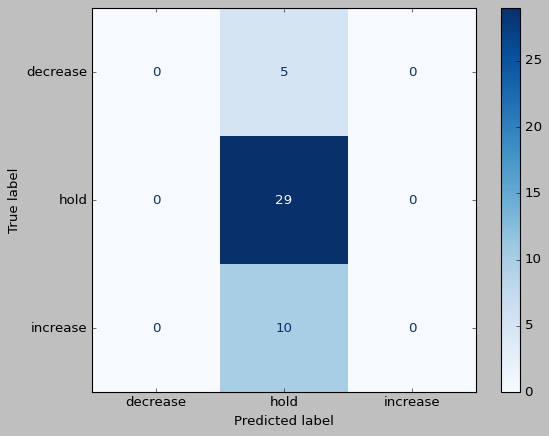

In [ ]:
y_pred_probs = model4a.predict(X_test_seq)

y_pred = np.argmax(y_pred_probs,
                   axis = 1)
y_true = np.argmax(y_test_seq,
                   axis = 1)

cm = confusion_matrix(y_true, y_pred)
class_names = ['decrease', 'hold', 'increase']


disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = class_names)
disp.plot(cmap = 'Blues', values_format ='d')

### 5.2 Scores

* F1 score
* accuracy
* precision
* recall

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

## 6 Discussion

What went wrong -  a lot! lets start with the data. there are very few observations, less than 300, probably not enough for a model to learn patterns. I wanted to use a real-life data set to run into real-life problems, and I certainly achieved that. Finding historical data from the previous century would be time consuming. Also, the Bank of Canada has changed its monetary policy several times, and a model that spans several different policies would be problematic. Given further time and resources - such as guidance from an economist or a paycheque to do the work - more research would need to be conducted to expand on the list of economic indicators to be included in the model.

A lot of volatility and noise in the data - perhaps some smoothing would have helped here.

Should have downloaded the monthly tsx closing data in the first place, as opposed to the daily and then converting to monthly. lol whoops.

Outliers - i really should have thought about smoothing out some of them, particulary around 2020 when everything gound to a halt so that it didn't have such an effect on the interest rates?

More feature engineering - could better performance be found with lag features explicitly added?

Hyperparameter tuning was slow. My previous area of study was statistics, and I'm working on catching up on the algorithms skills. The tuning process I used would not scalable as it is now, and would need further refinement.



## 7 Conclusion

Create a deep learning model(s) to capture time series nature of economic indicators and to predict the class of interest rate change - either decrease, hold, or increase - in advance of an interest rate change announcement.

This project began with loading in (most of) the data from Statistics Canada and the Bank of Canada, followed by some EDA, cleaning, and wrangling. Initial models were created using a vanilla RNN architecture, followed by GRU models and LSTM models.

Hyperparameters were tuned for the best model, and evaluated using a confusion matrix and a classification report. While the models overall did perform very well (likely due to the limited data size), I feel it was a decent start to deep learning and this project will provide a platform upon which I can build for future classification tasks.

## 8 References

1. [Bank of Canada Monetary Policy](https://www.bankofcanada.ca/core-functions/monetary-policy/)
2. [Policy Interest Rate](https://www.bankofcanada.ca/core-functions/monetary-policy/key-interest-rate/)
3. [Bank of Canada Publications](https://www.bankofcanada.ca/publications/browse/)

4. [Statistics Canada](https://www150.statcan.gc.ca/n1/en/type/data?MM=1)

5. [Bank of Canada Monthly Exchange rates](https://www.bankofcanada.ca/rates/exchange/monthly-exchange-rates/)

6. [Yahoo! Finance Historical TSX Close](https://ca.finance.yahoo.com/quote/%5EGSPTSE/history/?frequency=1mo&period1=1594934049&period2=1752700435)

7. [openAI - Not fooling anyone by trying to claim all code as my own](https://chatgpt.com/)

8. [LSTM Time Series](https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/)

9. All dtsa 5511 course notes, lectures, slides, assignments, and any other course material was referenced throughout.

10. [Bank of Canada inflation target](https://www.bankofcanada.ca/rates/indicators/key-variables/inflation-control-target/)

11. [RNN vs GRU vs LSTM](https://www.geeksforgeeks.org/deep-learning/rnn-vs-lstm-vs-gru-vs-transformers/)

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/





In [ ]:
!pip install keras-tuner -q

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

    model.add(Bidirectional(GRU(units=hp.Int('gru1_units', min_value=32, max_value=128, step=32), return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(GRU(units=hp.Int('gru2_units', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='bank_of_canada'
)

In [ ]:
tuner.search(X_train_seq, y_train_seq, epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop, reduce_lr], class_weight=class_weights)